In [ ]:
%matplotlib inline  

In [2]:
import torch
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib as mpl

import os
import sys

In [ ]:
os.chdir("..")

In [ ]:
from optbnn.gp.models.gpr import GPR
from optbnn.gp import kernels, mean_functions
from optbnn.bnn.reparam_nets import GaussianMLPReparameterization
from optbnn.bnn.nets.mlp import MLP
from optbnn.bnn.likelihoods import LikGaussian
from optbnn.bnn.priors import FixedGaussianPrior, OptimGaussianPrior
from optbnn.prior_mappers.wasserstein_mapper import MapperWasserstein, WassersteinDistance
from optbnn.utils.rand_generators import MeasureSetGenerator, GridGenerator
from optbnn.utils.normalization import normalize_data, zscore_normalization, zscore_unnormalization
from optbnn.metrics.sampling import compute_rhat_regression
from optbnn.utils import util
from optbnn.sgmcmc_bayes_net.regression_net import RegressionNet

In [3]:
mpl.rcParams['figure.dpi'] = 100

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
OUT_DIR = "./exp/1D_synthetic/tanh_gaussian_new"
FIG_DIR = os.path.join(OUT_DIR, "figures")
util.ensure_dir(OUT_DIR)
util.ensure_dir(FIG_DIR)

In [6]:
SEED = 1
util.set_seed(SEED)

# Utilities

In [21]:
def make_random_gap(X, gap_ratio=0.2):
    a,b = X.min(),X.max()
    gap_a = a + np.random.rand() * (b-a)*(1-gap_ratio)
    gap_b = gap_a + (b-a)*gap_ratio
    idx = np.logical_and(gap_a<X, X<gap_b)
    if gap_a-a > b-gap_b:
        X[idx] = a + np.random.rand(idx.sum()) * (gap_a-a)
    else:
        X[idx] = gap_b + np.random.rand(idx.sum()) * (b-gap_b)

def gp_sample(X, ampl=1, leng=1, sn2=0.1):
    n, x = X.shape[0], X / leng
    sum_xx = np.sum(x*x, 1).reshape(-1, 1).repeat(n, 1)
    D = sum_xx + sum_xx.transpose() - 2 * np.matmul(x, x.transpose())
    C = ampl**2 * np.exp(-0.5 * D) + np.eye(n) * sn2
    return np.random.multivariate_normal(np.zeros(n), C).reshape(-1, 1)

def plot_samples(X, samples, var=None, n_keep=12, color="xkcd:bluish", smooth_q=False, ax=None):
    if ax is None: 
        ax = plt.gca()
    if samples.ndim > 2:
        samples = samples.squeeze()
    n_keep = int(samples.shape[1]/10) if n_keep is None else n_keep
    keep_idx = np.random.permutation(samples.shape[1])[:n_keep]
    mu = samples.mean(1)
    if var is None:
        q=97.72  ## corresponds to 2 stdevs in Gaussian
        # q = 99.99  ## corresponds to 3 std
        Q = np.percentile(samples, [100-q, q], axis=1)
        # ub, lb = Q[1,:], Q[0,:]
        ub, lb = mu + 2 * samples.std(1), mu - 2 * samples.std(1)
        if smooth_q:
            lb = moving_average(lb)
            ub = moving_average(ub)
    else:
        ub = mu + 3 * np.sqrt(var)
        lb = mu - 3 * np.sqrt(var)
    ####
    ax.fill_between(X.flatten(), ub, lb, color=color, alpha=0.25, lw=0)
    ax.plot(X, samples[:, keep_idx], color=color, alpha=0.8)
    ax.plot(X, mu, color='xkcd:red')

# Generate data


In [8]:
util.set_seed(1)

In [9]:
N = 64
M = 100
a, b = -10, 10

# Generate data
X = np.random.rand(N, 1) * (b-a) + a
make_random_gap(X, gap_ratio=0.4)
y = gp_sample(X, ampl=1.6, leng=1.8)
Xtest = np.linspace(a-5, b+5, M).reshape(-1, 1)

# Normalize the dataset
X_, X_mean, X_std = zscore_normalization(X)
y_, y_mean, y_std = zscore_normalization(y)
Xtest_, _, _ = zscore_normalization(Xtest, X_mean, X_std)

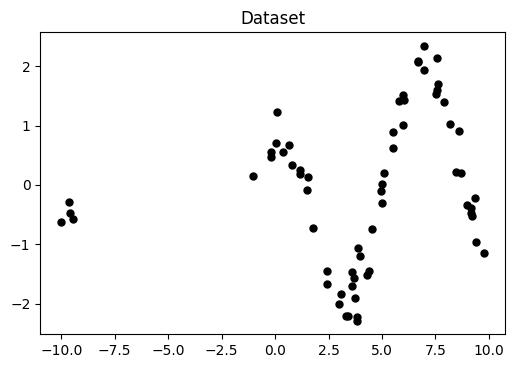

In [10]:
fig = plt.figure()
plt.plot(X, y, "ko", ms=5)
plt.title("Dataset")
plt.show()

In [11]:
Xtest_tensor = torch.from_numpy(Xtest_).to(device)

# Initialize Priors

In [12]:
# GP hyper-parameters
sn2 = 0.1
leng = 0.6
ampl = 1.0

# Initialize GP 
kernel = kernels.RBF(
        input_dim=1, ARD=True,
        lengthscales=torch.tensor([leng], dtype=torch.double),
        variance=torch.tensor([ampl], dtype=torch.double))

gpmodel = GPR(X=torch.from_numpy(X_).to(device),
              Y=torch.from_numpy(y_).reshape([-1, 1]).to(device),
              kern=kernel, mean_function=mean_functions.Zero())
gpmodel.likelihood.variance.set(sn2)
gpmodel = gpmodel.to(device)

In [13]:
# Initialize BNN Priors
width = 50
depth = 3
transfer_fn = "tanh"

std_bnn = GaussianMLPReparameterization(input_dim=1, output_dim=1, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth)

opt_bnn = GaussianMLPReparameterization(input_dim=1, output_dim=1, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth)

std_bnn = std_bnn.to(device)
opt_bnn = opt_bnn.to(device)

# Optimize Prior

In [14]:
data_generator = GridGenerator(-6, 6)

In [15]:
mapper_num_iters = 800

In [16]:
mapper = MapperWasserstein(gpmodel, opt_bnn, data_generator,
                            out_dir=OUT_DIR, 
                            wasserstein_steps=(0, 1000),
                            wasserstein_lr=0.08,
                            n_data=200, n_gpu=1, gpu_gp=True)
w_hist = mapper.optimize(num_iters=mapper_num_iters, n_samples=512, lr=0.01, 
                         save_ckpt_every=50, print_every=20, debug=True)
path = os.path.join(OUT_DIR, "wsr_values.log")
np.savetxt(path, w_hist, fmt='%.6e')        

>>> Iteration #   1: Wasserstein Dist 35.3518
>>> Iteration #  20: Wasserstein Dist 20.9743
>>> Iteration #  40: Wasserstein Dist 18.4331
>>> Iteration #  60: Wasserstein Dist 16.0816
>>> Iteration #  80: Wasserstein Dist 15.6529
>>> Iteration # 100: Wasserstein Dist 13.7069
>>> Iteration # 120: Wasserstein Dist 13.8300
>>> Iteration # 140: Wasserstein Dist 13.2826
>>> Iteration # 160: Wasserstein Dist 12.1828
>>> Iteration # 180: Wasserstein Dist 11.7094
>>> Iteration # 200: Wasserstein Dist 11.3823
>>> Iteration # 220: Wasserstein Dist 11.1262
>>> Iteration # 240: Wasserstein Dist 11.0729
>>> Iteration # 260: Wasserstein Dist 10.7412
>>> Iteration # 280: Wasserstein Dist 10.6169
>>> Iteration # 300: Wasserstein Dist 9.4420
>>> Iteration # 320: Wasserstein Dist 9.9283
>>> Iteration # 340: Wasserstein Dist 9.6681
>>> Iteration # 360: Wasserstein Dist 9.5776
>>> Iteration # 380: Wasserstein Dist 8.6121
>>> Iteration # 400: Wasserstein Dist 9.5261
>>> Iteration # 420: Wasserstein Dist 9.

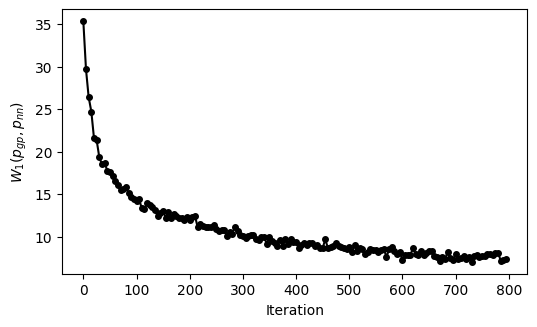

In [17]:
wdist_file = os.path.join(OUT_DIR, "wsr_values.log")
wdist_vals = np.loadtxt(wdist_file)

fig = plt.figure(figsize=(6, 3.5))
indices = np.arange(mapper_num_iters)[::5]
plt.plot(indices, wdist_vals[indices], "-ko", ms=4)
plt.ylabel(r"$W_1(p_{gp}, p_{nn})$")
plt.xlabel("Iteration")
plt.show()

# Visualize Prior

In [18]:
# Load the optimize prior
ckpt_path = os.path.join(OUT_DIR, "ckpts", "it-{}.ckpt".format(mapper_num_iters))
opt_bnn.load_state_dict(torch.load(ckpt_path))

<All keys matched successfully>

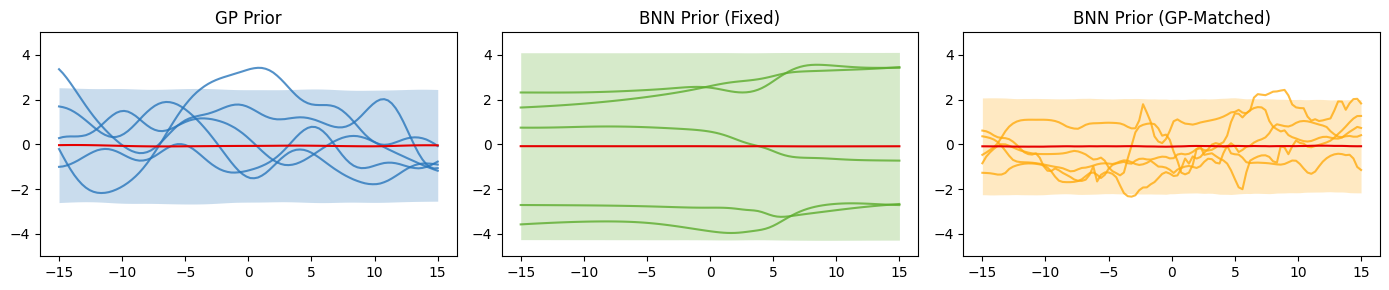

In [31]:
# Draw functions 
n_plot = 4000

gp_samples = gpmodel.sample_functions(
   Xtest_tensor, n_plot).detach().cpu().numpy().squeeze()
gp_samples = zscore_unnormalization(gp_samples, y_mean, y_std)

std_bnn_samples = std_bnn.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
std_bnn_samples = zscore_unnormalization(std_bnn_samples, y_mean, y_std)

opt_bnn_samples = opt_bnn.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
opt_bnn_samples = zscore_unnormalization(opt_bnn_samples, y_mean, y_std)


fig, axs = plt.subplots(1, 3, figsize=(14, 3))
plot_samples(Xtest, gp_samples, ax=axs[0], n_keep=5)
axs[0].set_title('GP Prior')
axs[0].set_ylim([-5, 5])

plot_samples(Xtest, std_bnn_samples, ax=axs[1], color='xkcd:grass', n_keep=5)
axs[1].set_title('BNN Prior (Fixed)')
axs[1].set_ylim([-5, 5])

plot_samples(Xtest, opt_bnn_samples, ax=axs[2], color='xkcd:yellowish orange', n_keep=5)
axs[2].set_title('BNN Prior (GP-Matched)')
axs[2].set_ylim([-5, 5])

plt.tight_layout()
plt.show()

# Posterior Inference


# GP


In [50]:
# Make predictions
gp_preds = gpmodel.predict_f_samples(Xtest_tensor, 1000)
gp_preds = gp_preds.detach().cpu().numpy().squeeze()
gp_preds = zscore_unnormalization(gp_preds, y_mean, y_std)

## BNN with Standard Gaussian Prior

In [52]:
# SGHMC Hyper-parameters
sampling_configs = {
    "batch_size": 32,
    "num_samples": 30,
    "n_discarded": 10,
    "num_burn_in_steps": 1000,
    "keep_every": 200,
    "lr": 0.01,
    "num_chains": 4,
    "mdecay": 0.01,
    "print_every_n_samples": 5
}

In [53]:
# Load the optimized prior
prior = FixedGaussianPrior(std=1.0)

# Setup likelihood
net = MLP(1, 1, [width]*depth, transfer_fn)
likelihood = LikGaussian(sn2)

# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_std")
util.ensure_dir(saved_dir)
bayes_net_std = RegressionNet(net, likelihood, prior, saved_dir, n_gpu=0)

# Start sampling
bayes_net_std.sample_multi_chains(X, y, **sampling_configs)

Chain: 0
Samples #     5 : NLL =  4.2831e-01 RMSE = 3.6524e-01 
Samples #    10 : NLL =  4.2220e-01 RMSE = 3.6262e-01 
Samples #    15 : NLL =  4.1075e-01 RMSE = 3.5592e-01 
Samples #    20 : NLL =  4.1122e-01 RMSE = 3.5696e-01 
Chain: 1
Samples #    25 : NLL =  4.0986e-01 RMSE = 3.5594e-01 
Samples #    30 : NLL =  4.0828e-01 RMSE = 3.5522e-01 
Samples #    35 : NLL =  4.0693e-01 RMSE = 3.5403e-01 
Samples #    40 : NLL =  4.0492e-01 RMSE = 3.5352e-01 
Chain: 2
Samples #    45 : NLL =  4.0759e-01 RMSE = 3.5483e-01 
Samples #    50 : NLL =  4.1285e-01 RMSE = 3.5725e-01 
Samples #    55 : NLL =  4.1552e-01 RMSE = 3.5820e-01 
Samples #    60 : NLL =  4.1878e-01 RMSE = 3.5962e-01 
Chain: 3
Samples #    65 : NLL =  4.1941e-01 RMSE = 3.5994e-01 
Samples #    70 : NLL =  4.2063e-01 RMSE = 3.6015e-01 
Samples #    75 : NLL =  4.2257e-01 RMSE = 3.6085e-01 
Samples #    80 : NLL =  4.1817e-01 RMSE = 3.5870e-01 


In [72]:
# Make predictions
_, _, bnn_std_preds = bayes_net_std.predict(Xtest, True)
r_hat = compute_rhat_regression(bnn_std_preds, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
bnn_std_preds = bnn_std_preds.squeeze().T

posterior_std_path = os.path.join(OUT_DIR, "posterior_std.npz")
np.savez(posterior_std_path, bnn_samples=bnn_std_preds)

R-hat: mean 1.0136 std 0.0243


## BNN with Optimized Gaussian Prior



In [74]:
# Load the optimized prior
ckpt_path = os.path.join(OUT_DIR, "ckpts", "it-{}.ckpt".format(mapper_num_iters))
prior = OptimGaussianPrior(ckpt_path)

# Setup likelihood
net = MLP(1, 1, [width]*depth, transfer_fn)
likelihood = LikGaussian(sn2)

# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_optim")
util.ensure_dir(saved_dir)
bayes_net_optim = RegressionNet(net, likelihood, prior, saved_dir, n_gpu=0)

# Start sampling
bayes_net_optim.sample_multi_chains(X, y, **sampling_configs)

Chain: 0
Samples #     5 : NLL =  2.6754e-01 RMSE = 2.5290e-01 
Samples #    10 : NLL =  2.6747e-01 RMSE = 2.5286e-01 
Samples #    15 : NLL =  2.6819e-01 RMSE = 2.5392e-01 
Samples #    20 : NLL =  2.7003e-01 RMSE = 2.5324e-01 
Chain: 1
Samples #    25 : NLL =  2.6796e-01 RMSE = 2.5232e-01 
Samples #    30 : NLL =  2.6781e-01 RMSE = 2.5056e-01 
Samples #    35 : NLL =  2.6841e-01 RMSE = 2.4873e-01 
Samples #    40 : NLL =  2.6642e-01 RMSE = 2.4698e-01 
Chain: 2
Samples #    45 : NLL =  2.6722e-01 RMSE = 2.4682e-01 
Samples #    50 : NLL =  2.6676e-01 RMSE = 2.4694e-01 
Samples #    55 : NLL =  2.6717e-01 RMSE = 2.4782e-01 
Samples #    60 : NLL =  2.6682e-01 RMSE = 2.4797e-01 
Chain: 3
Samples #    65 : NLL =  2.6568e-01 RMSE = 2.4754e-01 
Samples #    70 : NLL =  2.6473e-01 RMSE = 2.4783e-01 
Samples #    75 : NLL =  2.6343e-01 RMSE = 2.4749e-01 
Samples #    80 : NLL =  2.6299e-01 RMSE = 2.4784e-01 


In [75]:
# Make predictions
_, _, bnn_optim_preds = bayes_net_optim.predict(Xtest, True)
r_hat = compute_rhat_regression(bnn_optim_preds, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
bnn_optim_preds = bnn_optim_preds.squeeze().T

posterior_optim_path = os.path.join(OUT_DIR, "posterior_optim.npz")
np.savez(posterior_optim_path, bnn_samples=bnn_optim_preds)

R-hat: mean 1.0115 std 0.0286


# Visualize Predictive Posterior

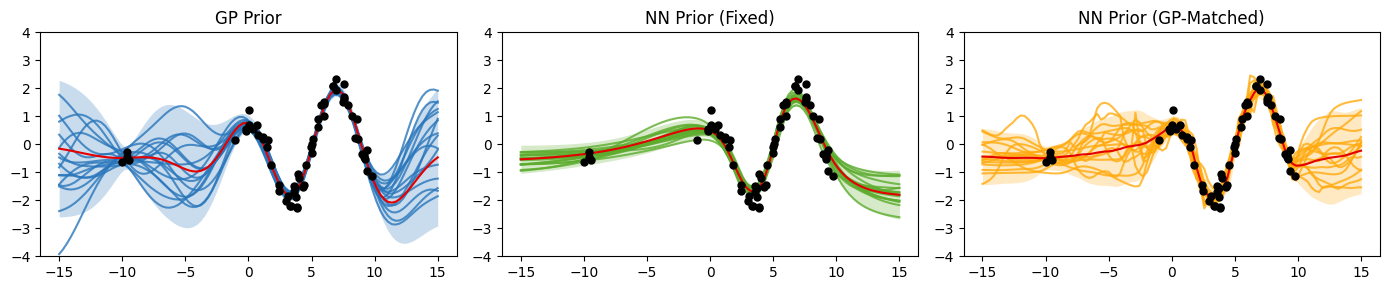

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

plot_samples(Xtest, gp_preds, ax=axs[0], n_keep=16)
axs[0].plot(X, y, 'ok', zorder=10, ms=5)
axs[0].set_title('GP Prior')
axs[0].set_ylim([-4, 4])

plot_samples(Xtest, bnn_std_preds, ax=axs[1], color='xkcd:grass', n_keep=16)
axs[1].plot(X, y, 'ok', zorder=10, ms=5)
axs[1].set_title('NN Prior (Fixed)')
axs[1].set_ylim([-4, 4])

plot_samples(Xtest, bnn_optim_preds, ax=axs[2], color='xkcd:yellowish orange', n_keep=16)
axs[2].plot(X, y, 'ok', zorder=10, ms=5)
axs[2].set_title('NN Prior (GP-Matched)')
axs[2].set_ylim([-4, 4])

plt.tight_layout()
plt.show()